In [ ]:
import jax
import jax.numpy as jnp

In [3]:
t = jnp.linspace(0, 20, 1000)

m = 1.
c = 0.1
k = 1.
y0 = 1.
y0_prime = 0.


# create a one layer neural network with `tanh` activation function
def nn(params, t):
    return params['W2'] @ jnp.tanh(params['W1'] * t + params['b1']) + params['b2']


initializer = jax.nn.initializers.glorot_uniform()
key = jax.random.PRNGKey(42)
*init_keys, key = jax.random.split(key, 5)

h = 30
params = {
    'W1': initializer(init_keys[0], (h, 1), jnp.float32)[:, 0],
    'W2': initializer(init_keys[1], (1, h), jnp.float32)[0, :],
    'b1': initializer(init_keys[2], (h, 1), jnp.float32)[:, 0],
    'b2': initializer(init_keys[3], (1, 1), jnp.float32)[0, 0],
}

nn(params, t[0])

DeviceArray(1.6353983, dtype=float32)

We want to train the neural network for the ODE 

$$
m * \ddot y + c * \dot y + k * y = 0,
$$
with $m = 1, c = 0.1$ and $k = 1$. 

Therefore we define an objective 

$$
\mathcal{L}(\mathbf{W}) = \frac{1}{M}\sum_{i=1}^M (m * \ddot y_\mathbf{W}(t_i) + c * \dot y_\mathbf{W}(t_i) + k * y_\mathbf{W}(t_i)) ^ 2 + (y_\mathbf{W}(0) - y_0) ^ 2 + (\dot y_\mathbf{W}(0) - \dot y_0) ^ 2
$$

In [5]:

def ode(params, t):
    _nn = lambda t: nn(params, t)
    dnn = jax.grad(_nn)
    ddnn = jax.grad(dnn)
    return m * ddnn(t) + c * dnn(t) + k * _nn(t)

def objective(params, ts):
    ys = jax.vmap(ode, (None, 0))(params, ts)
    ode_loss = jnp.mean(ys ** 2)
    init_loss1 = (nn(params, 0.) - y0) ** 2
    init_loss2 = (jax.grad(nn, 1)(params, 0.) - y0_prime) ** 2
    return ode_loss + init_loss1 + init_loss2

objective(params, t)


DeviceArray(1.1016932, dtype=float32)

In [11]:
import optax

def fit(params: optax.Params, optimizer: optax.GradientTransformation, key) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(objective)(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for epoch in range(5000):
        shuffle_key, key = jax.random.split(key)
        batches = jax.random.permutation(shuffle_key, t)
        batches = batches.reshape(10, -1)
        for batch in batches:
            params, opt_state, loss_value = step(params, opt_state, batch)
        if epoch % 100 == 0:
            print(f'epoch {epoch}, loss: {loss_value}')
    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-2)
train_key, key = jax.random.split(key)
params = fit(params, optimizer, key)


epoch 0, loss: 0.008357535116374493
epoch 100, loss: 0.0016060590278357267
epoch 200, loss: 0.0016492761205881834
epoch 300, loss: 0.0018626804230734706
epoch 400, loss: 0.001124930684454739
epoch 500, loss: 0.001286556595005095
epoch 600, loss: 0.0016241867560893297
epoch 700, loss: 0.0015612852293998003
epoch 800, loss: 0.0011045141145586967
epoch 900, loss: 0.0006602283101528883
epoch 1000, loss: 0.000877952144946903
epoch 1100, loss: 0.0007409605314023793
epoch 1200, loss: 0.0019194679334759712
epoch 1300, loss: 0.00037316870293579996
epoch 1400, loss: 0.0002645572239998728
epoch 1500, loss: 0.0004721670120488852
epoch 1600, loss: 0.001579388976097107
epoch 1700, loss: 0.00015750373131595552
epoch 1800, loss: 0.00022295780945569277
epoch 1900, loss: 0.0003517207223922014
epoch 2000, loss: 0.000317901314701885
epoch 2100, loss: 0.0001806102372938767
epoch 2200, loss: 0.0003105367359239608
epoch 2300, loss: 0.00048429108574055135
epoch 2400, loss: 0.0002657227742020041
epoch 2500, lo

In [13]:
# import jaxopt
# solver = jaxopt.LBFGS(fun=objective)
# params = solver.run(params, t).params

In [7]:
def sol(t):
    r1 = - c / (2 * m) + 1 / (2*m) * (c ** 2 - 4 * k * m) ** (1 / 2)
    r2 = - c / (2 * m) - 1 / (2*m) * (c ** 2 - 4 * k * m) ** (1 / 2)
    c2 = r1 / (r1 - r2)
    c1 = 1 - c2
    return c1 * jnp.exp(r1 * t) + c2 * jnp.exp(r2 * t)


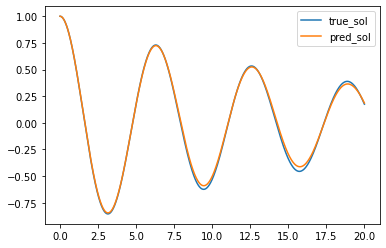

In [12]:
import matplotlib.pyplot as plt

model = jax.vmap(lambda t: nn(params, t))

plt.plot(t, jnp.real(sol(t)), label='true_sol')
plt.plot(t, model(t), label='pred_sol')
plt.legend()